In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gzip
import lasagne
from lasagne import layers
from nolearn.lasagne import NeuralNet
from lasagne.updates import sgd
from utility import *
%load_ext autoreload
%autoreload 2
%pylab inline

ERROR (theano.sandbox.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/theano/sandbox/gpuarray/__init__.py", line 95, in <module>
    init_dev(config.device)
  File "/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/theano/sandbox/gpuarray/__init__.py", line 46, in init_dev
    "Make sure Theano and libgpuarray/pygpu "
RuntimeError: ('Wrong major API version for gpuarray:', 2, 'Make sure Theano and libgpuarray/pygpu are in sync.')


Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * f

In [ ]:
pylab.rcParams['figure.figsize'] = (15, 9)
sys.setrecursionlimit(10000)
conv2d1_filters_numbers = 8
conv2d1_filters_size = 9
conv2d2_filters_numbers = 8
conv2d2_filters_size = 1
conv2d3_filters_numbers = 1
conv2d3_filters_size = 5

down_sample_ratio = 16
learning_rate = 0.00001
epochs = 2
HiC_max_value = 100

In [3]:
low_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_down16_chr19_22.npy.gz', "r")) * down_sample_ratio
high_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_original_chr19_22.npy.gz', "r"))
low_resolution_samples, high_resolution_samples, cache = loadData(40, 40, 28, 28, root="../../")
low_resolution_samples = low_resolution_samples.reshape(-1, 1, 40, 40).astype('float32')
high_resolution_samples = high_resolution_samples.reshape(-1, 1, 40, 40).astype('float32')

Starting to load data...
expected:  17 17
actual: 17 17 289
expected:  17 17
actual: 17 17 289
expected:  17 16
actual: 17 16 272
expected:  17 16
actual: 17 16 272
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 12
actual: 17 12 204
expected:  17 12
actual: 17 12 204
expected:  17 11
actual: 17 11 187
expected:  17 11
actual: 17 11 187
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 6
act

finished loading data


In [4]:
print(low_resolution_samples.shape)
print(high_resolution_samples.shape)

(20022, 1, 40, 40)
(20022, 1, 40, 40)


In [5]:
sample_size = low_resolution_samples.shape[-1]
padding = conv2d1_filters_size + conv2d2_filters_size + conv2d3_filters_size - 3
half_padding = padding // 2
output_length = sample_size - padding
print(sample_size)
print(output_length)

40
28


In [6]:
Y = high_resolution_samples[:, 0, half_padding:(sample_size-half_padding), half_padding:(sample_size-half_padding)]
Y = Y.reshape(Y.shape[0], -1)
X = low_resolution_samples

In [7]:
print(X.shape)
print(Y.shape)

(20022, 1, 40, 40)
(20022, 784)


In [29]:
net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv2d1', layers.Conv2DLayer),
        ('conv2d2', layers.Conv2DLayer),
        ('conv2d3', layers.Conv2DLayer),
        ('output_layer', layers.FlattenLayer),
        ],
    input_shape=(None, 1, sample_size, sample_size),
    conv2d1_num_filters=conv2d1_filters_numbers,
    conv2d1_filter_size = (conv2d1_filters_size, conv2d1_filters_size),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),
    conv2d2_num_filters=conv2d2_filters_numbers,
    conv2d2_filter_size = (conv2d2_filters_size, conv2d2_filters_size),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d3_num_filters=conv2d3_filters_numbers,
    conv2d3_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d3_filter_size = (conv2d3_filters_size, conv2d3_filters_size),
    update=sgd,
    update_learning_rate = learning_rate,
    regression=True,
    max_epochs= epochs,
    verbose=1,
    )

In [30]:
AllPredicted = []
output_model_name = '../model/test_model'
f = open(output_model_name, 'wb')
pickle.dump(net1,f,protocol=pickle.HIGHEST_PROTOCOL)
f.close()
print("iteration: ", i)
net1.fit(X, Y)
AllPredicted.append(net1.predict(low_resolution_samples))

iteration:  1


/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 929 learnable parameters

## Layer information

  #  name          size
---  ------------  -------
  0  input         1x40x40
  1  conv2d1       8x32x32
  2  conv2d2       8x32x32
  3  conv2d3       1x28x28
  4  output_layer  784

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     1.81733     1.61356    1.12629  21.39s
      2     1.73022     1.53479    1.12733  21.35s
      3     1.64300     1.45778    1.12705  21.57s
      4     1.55864     1.38434    1.12591  21.35s
      5     1.47881     1.31520    1.12440  21.33s
      6     1.40403     1.25065    1.12264  21.52s
      7     1.33464     1.19074    1.12085  21.46s
      8     1.27069     1.13571    1.11885  21.77s
      9     1.21240     1.08578    1.11661  21.09s
     10     1.15983     1.04087    1.11429  20.88s


In [13]:
output_model_name = '../model/test_model'

f = open(output_model_name, 'wb')

pickle.dump(net1,f,protocol=pickle.HIGHEST_PROTOCOL)
f.close()

In [14]:
output_model_name = '../model/test_model'

f = open(output_model_name + '.net', 'rb')
net1 = pickle.load(f)

In [16]:
print("number of contact maps: ", len(cache))
cacheIndex = 1
def reconstructFromIndex(cache, predicted, cacheIndex):
    sum = 0
    for i in range(cacheIndex):
       sum += cache[i][0] 
    N, cacheLow, cacheHigh = cache[cacheIndex]
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = cacheLow
    assert N == a9 * a10
    mout = predicted[sum:sum+N].reshape(a9, a10, 28, 28)
    #print(mout.shape )
    #mout = low_resolution_samples[:289, 0, 6:34, 6:34].reshape(17, 17, 28, 28)
    #print(mout.shape )
    out = np.zeros((a9*28, a10*28))
    for i in range(a9-1):
        for j in range(a10-1):
            out[i*28:(i+1)*28, j*28:(j+1)*28] = mout[i, j]
    return out
#for cacheIndex in range(len(cache)):
def reconstructFromFeatures(low_resolution_samples, high_resolution_samples, predicted):
    height = 0
    width = 0
    size_dict = {}
    nss = np.zeros(24, dtype='int32')
    cacheIndex = 0
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            lowReconstructedByIndex = low_resolution_samples[:, 0, 6:34, 6:34]
            lowReconstructedByIndex = reconstructFromIndex(cache, lowReconstructedByIndex, cacheIndex)
            #print("shape: ", lowReconstructedByIndex.shape)
            predReconstructedByIndex = reconstructFromIndex(cache, predicted, cacheIndex)
            highReconstructedByIndex = reconstructFromIndex(cache, Y, cacheIndex)
            #ax = plt.subplot(1, 3, 1)
            #ax.imshow(lowReconstructedByIndex)   
            #ax = plt.subplot(1, 3, 2)
            #ax.imshow(predReconstructedByIndex)
            #ax = plt.subplot(1, 3, 3)
            #ax.imshow(highReconstructedByIndex)
            plt.show()
            cacheIndex += 1
            assert lowReconstructedByIndex.shape[0] == highReconstructedByIndex.shape[0]
            assert lowReconstructedByIndex.shape[1] == highReconstructedByIndex.shape[1]
            assert predReconstructedByIndex.shape[0] == highReconstructedByIndex.shape[0]
            assert predReconstructedByIndex.shape[1] == highReconstructedByIndex.shape[1]
            size_dict[(chr1, chr2)] = \
                (lowReconstructedByIndex, highReconstructedByIndex\
                 , predReconstructedByIndex)
            nss[chr1] = np.max([lowReconstructedByIndex.shape[0], nss[chr1]])

    width = height = int(np.sum(nss))
    print("H and W:", width, height)
    lowReconstructed = np.zeros((height, width) )
    highReconstructed = np.zeros((height, width))
    predReconstructed = np.zeros((height, width))
    cacheIndex=0
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            lowReconstructedByIndex = low_resolution_samples[:, 0, 6:34, 6:34]
            lowReconstructedByIndex = reconstructFromIndex(cache, lowReconstructedByIndex, cacheIndex)
            #print("shape: ", lowReconstructedByIndex.shape)
            predReconstructedByIndex = reconstructFromIndex(cache, predicted, cacheIndex)
            highReconstructedByIndex = reconstructFromIndex(cache, Y, cacheIndex)
            lowReconstructedByIndex, highReconstructedByIndex, predReconstructedByIndex = size_dict[(chr1, chr2)]
            H = int(nss[:chr1].sum())
            W = int(nss[:chr2].sum())
            h, w = lowReconstructedByIndex.shape
            #print(chr1, chr2, H, W, h, w, lowReconstructedByIndex.shape)
            lowReconstructed[H:H+h, W:W+w] = lowReconstructedByIndex * 1.
            highReconstructed[H:H+h, W:W+w] = highReconstructedByIndex * 1.
            predReconstructed[H:H+h, W:W+w] = predReconstructedByIndex * 1.
            if chr1 != chr2:
                lowReconstructed[W:W+w, H:H+h] = lowReconstructedByIndex.T * 1.
                highReconstructed[W:W+w, H:H+h] = highReconstructedByIndex.T * 1.
                predReconstructed[W:W+w, H:H+h] = predReconstructedByIndex.T * 1.            
            cacheIndex += 1
    return lowReconstructed, highReconstructed, predReconstructed, size_dict


number of contact maps:  276


In [17]:
predictedIndex = 0
lowReconstructed, highReconstructed, predReconstructed, size_dict = reconstructFromFeatures(low_resolution_samples\
                                                                                           , high_resolution_samples\
                                                                                           , AllPredicted[predictedIndex])
chr1 = 5
chr2 = 6
H, W = (np.sum(nss[:chr1]), np.sum(nss[:chr2]))
h, w = size_dict[(chr1, chr2)][1].shape
a = size_dict[(chr1, chr2)][1]
b = highReconstructed[H:H+h, W:W+w]
print("Relative Error: ", rel_error(a, b))

IndexError: list index out of range

In [21]:
print(AllPredicted)

[]


Number of rows and columns: 1, 3


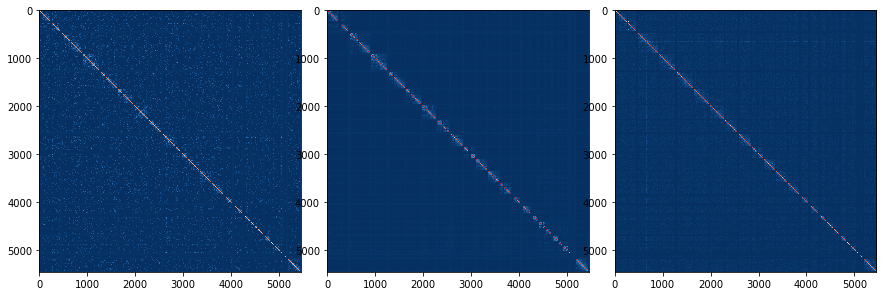

In [166]:
showImages([lowReconstructed, highReconstructed, predReconstructed])

(16, 3, 28, 28)
shape:  (448, 84)
(16, 3, 28, 28)
(16, 3, 28, 28)


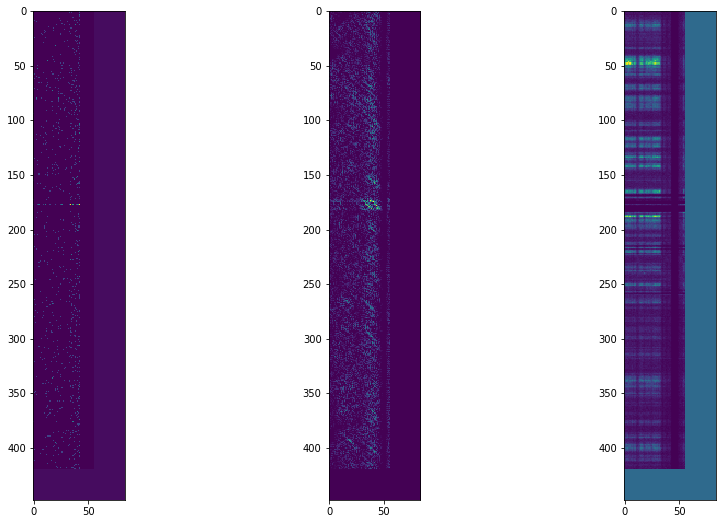

(16, 4, 28, 28)
shape:  (448, 112)
(16, 4, 28, 28)
(16, 4, 28, 28)


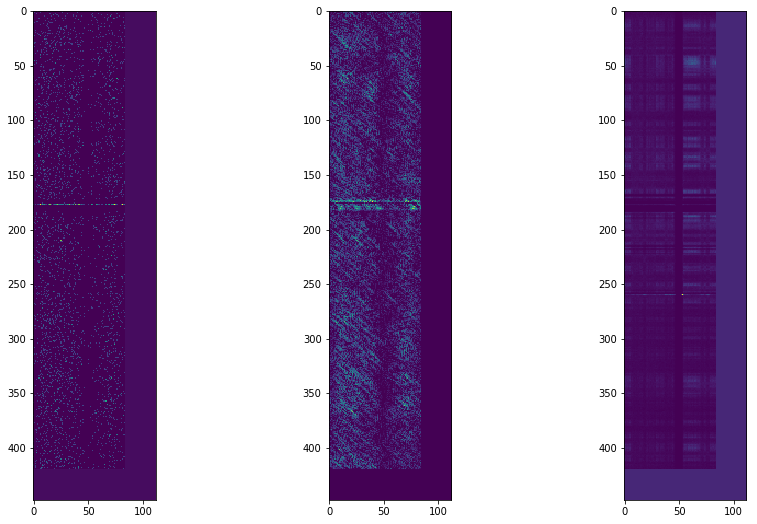

(16, 2, 28, 28)
shape:  (448, 56)
(16, 2, 28, 28)
(16, 2, 28, 28)


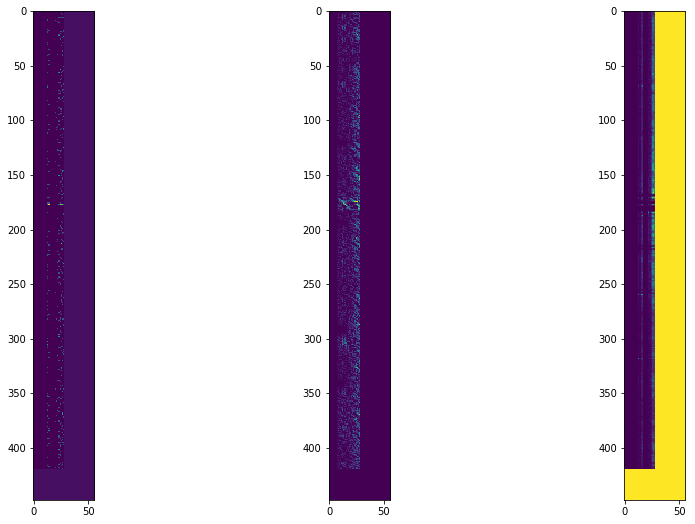

(16, 3, 28, 28)
shape:  (448, 84)
(16, 3, 28, 28)
(16, 3, 28, 28)


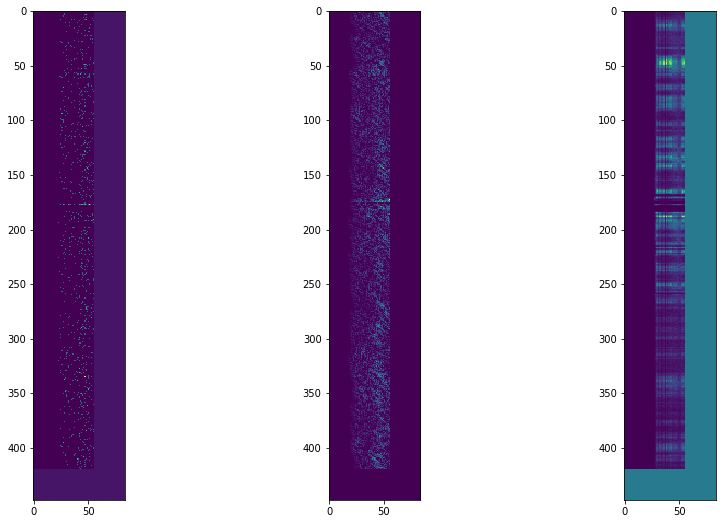

(16, 10, 28, 28)
shape:  (448, 280)
(16, 10, 28, 28)
(16, 10, 28, 28)


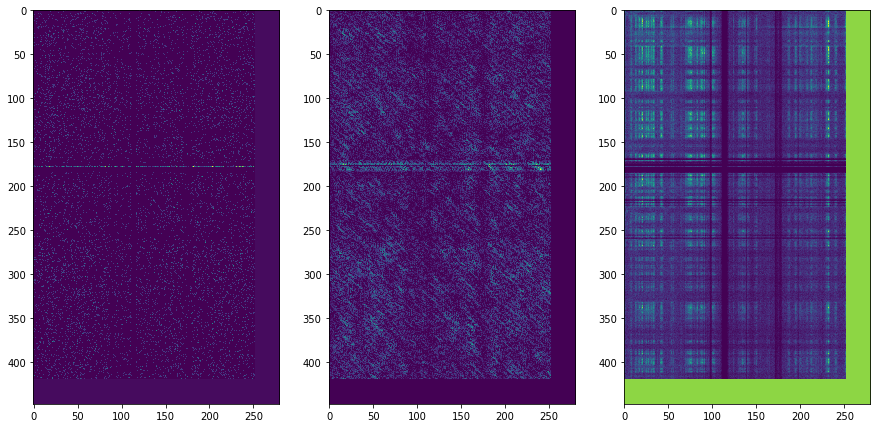

(13, 13, 28, 28)
shape:  (364, 364)
(13, 13, 28, 28)
(13, 13, 28, 28)


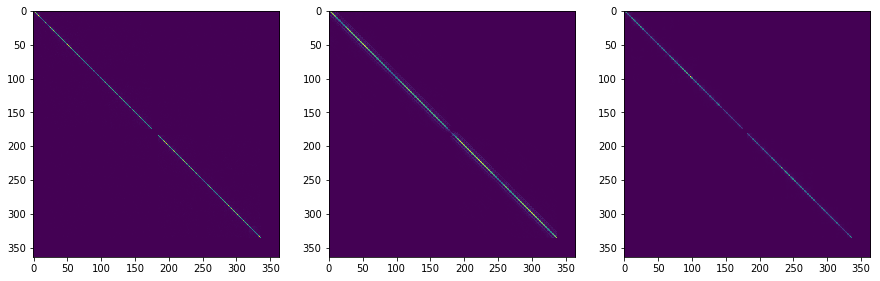

(13, 13, 28, 28)
shape:  (364, 364)
(13, 13, 28, 28)
(13, 13, 28, 28)


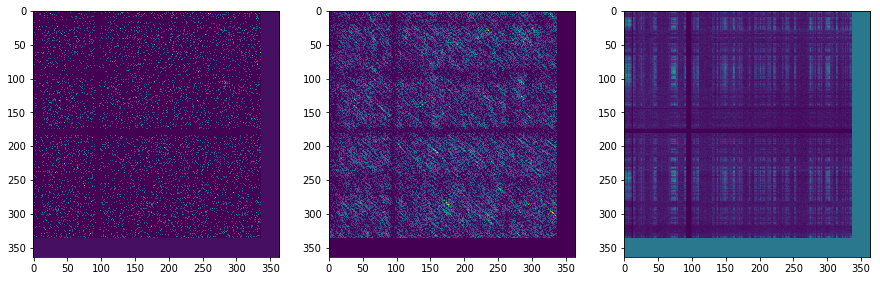

(13, 12, 28, 28)
shape:  (364, 336)
(13, 12, 28, 28)
(13, 12, 28, 28)


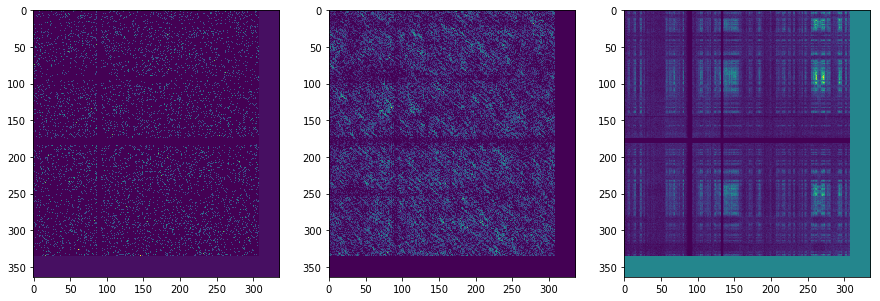

(13, 11, 28, 28)
shape:  (364, 308)
(13, 11, 28, 28)
(13, 11, 28, 28)


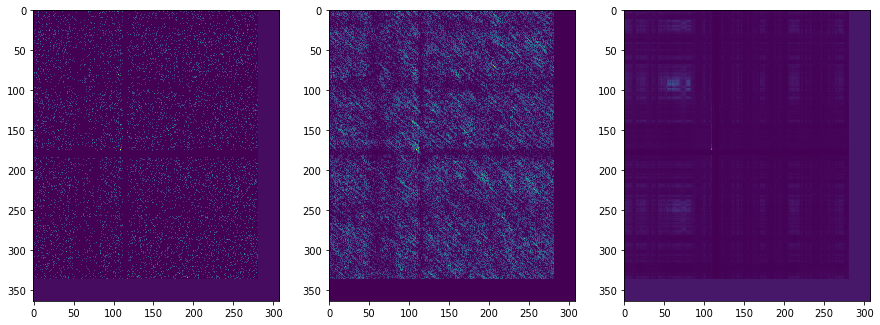

(13, 10, 28, 28)
shape:  (364, 280)
(13, 10, 28, 28)
(13, 10, 28, 28)


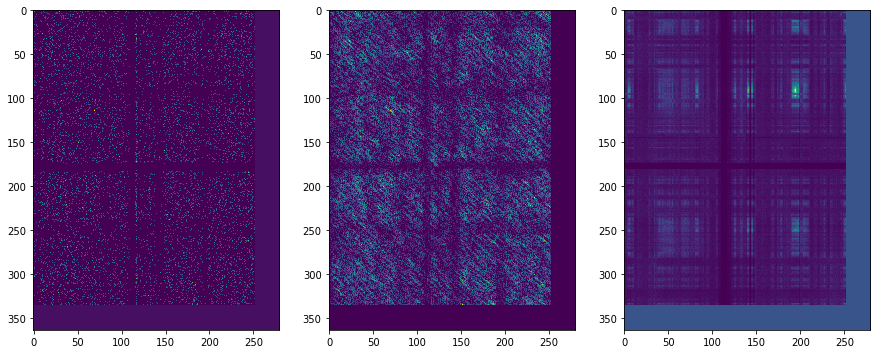

In [11]:
cacheIndex = 1
def mardas(cache, predicted, cacheIndex):
    sum = 0
    for i in range(cacheIndex):
       sum += cache[i][0] 
    N, cacheLow, cacheHigh = cache[cacheIndex]
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = cacheLow
    assert N == a9 * a10
    mout = predicted[sum:sum+N].reshape(a9, a10, 28, 28)
    #print(mout.shape )
    #mout = low_resolution_samples[:289, 0, 6:34, 6:34].reshape(17, 17, 28, 28)
    print(mout.shape )
    out = np.zeros((a9*28, a10*28))
    for i in range(a9-1):
        for j in range(a10-1):
            out[i*28:(i+1)*28, j*28:(j+1)*28] = mout[i, j]
    return out
#for cacheIndex in range(len(cache)):
for cacheIndex in range(40, 50):
    out0 = low_resolution_samples[:, 0, 6:34, 6:34]
    out0 = mardas(cache, out0, cacheIndex)
    print("shape: ", out0.shape)
    out1 = mardas(cache, predicted, cacheIndex)
    out2 = mardas(cache, Y, cacheIndex)
    ax = plt.subplot(1, 3, 1)
    ax.imshow(out0)   
    ax = plt.subplot(1, 3, 2)
    ax.imshow(out1)
    ax = plt.subplot(1, 3, 3)
    ax.imshow(out2)
    plt.show()